In [556]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Import Packages

In [610]:
import pandas as pd
import numpy as np
import re
from clean import *

#### Write all csv files in the data folder to text file in current directory

In [611]:
!ls ./data > data.txt

#### Read in data.txt and create dataframe df from raw data

In [612]:
with open('data.txt','r') as f:
    lines = f.readlines()

data = []   
for line in lines:
    data.append(pd.read_csv('./data/'+line[:-1]))

df_raw = pd.concat(data)

#### Clean and generate new columns with clean.py and export cleaned data to csv

In [613]:
df = clean(df_raw)
df.to_csv('data_cleaned.csv')
df.shape
df = df.dropna(subset=['price'])
df.shape

(11813, 16)

(9217, 16)

## Read in Latitude and Longitude Dataset 

In [60]:
latlon = pd.read_csv('./extra-data/us-zip-geom.csv', 
                     header=0, 
                     names = ['city','state','lat','lon'],
                     usecols = [1,2,3,4],
                    index_col=False)

# Artifact from cities with multiple zipcodes. 
latlon = latlon.drop_duplicates(subset=['city'])

In [61]:
latlon.sample(4)
latlon.shape

city state        lat        lon
1695     Palm Coast    FL  29.466085 -81.282815
29133  Severna Park    MD  39.079059 -76.557840
39524         Perth    ND  48.742513 -99.427440
36252       Boonton    NJ  40.912798 -74.415160

(19053, 4)

In [62]:
df = pd.merge(df, latlon, on=['city','state'], how='left')

In [63]:
df.sample(3)

address     amenities  buildingSize  \
3936  1056 NE 43rd Ct Oakland Park, FL USA  [Fenced Lot]        3200.0   
3261   4020 Flowserve Way Pasadena, TX USA          None       36954.0   
1737     565 Lloyd Ln Independence, OR USA          None       11965.0   

              city listingDate  price    propType  spaceAvailable  spaces  \
3936  Oakland Park  2020-02-19   1.13  Industrial            3200       1   
3261      Pasadena  2019-05-07   0.85  Industrial           36954       1   
1737  Independence  2020-03-23   0.55  Industrial           11965       2   

     state  ...                                          transport  \
3936    FL  ...  {'Cypress Creek Commuter Rail (Tri-County Comm...   
3261    TX  ...  {'Ellington Field Airport': [10.2, 23.0, 26.6]...   
1737    OR  ...                                                 {}   

                  utilities yearBuilt  yearRenovated  ceilingHeight  \
3936                     []      1967           1967             10   
3261                     []      2018           2018             10   
1737  [Gas, Sewer, Heating]      2020           2020             10   

      numDriveIns  numLoadingDocks  \
3936            2                1   
3261            1                1   
1737            1                1   

                                               propInfo lat  lon  
3936  \nNewly renovated with Impact storefront windo... NaN  NaN  
3261  \nTiltwall Construction\n• Building is Expanda... NaN  NaN  
1737  \nBUILDING 1:\n*Approximately 4,400 SF (approx... NaN  NaN  

[3 rows x 21 columns]

## Create Transport Dictionary
For every transportation connections pulled in from the listing, I aggregate the speedOfTravel (calculated by dividing the distance by time (converted to hours) to get an estimated measure of traffic/congestion in that area.

In [65]:
# Create an empty list to house the extracted values
lst = []
# Enumerate for every dictionary entry in the transport column
for i,dic in enumerate(df.transport):
    state, city, lat,lon = df.iloc[i][['state','city','lat','lon']]
    city = city + ', ' + state
    for k,v in dic.items():
        lst.append([i, state, city, lat,lon, k, *v])

transport_df = pd.DataFrame(lst, columns=['index','state','city','lat','lon', 'name','distance','timeTo','speedOfTravel'])

The new dataframe, **transport_df**, preserves the index of the entry it's tied to in the original dataframe, **df**

\*Note\* In this case the geom point corresponds to the city no the 'name' of the transportation hub

In [66]:
transport_df.head(5)

index state         city        lat       lon  \
0      0    TX  Houston, TX  29.733181 -95.43131   
1      0    TX  Houston, TX  29.733181 -95.43131   
2      0    TX  Houston, TX  29.733181 -95.43131   
3      0    TX  Houston, TX  29.733181 -95.43131   
4      1    TX  Houston, TX  29.733181 -95.43131   

                                           name  distance  timeTo  \
0  Houston George Bush Intercontinental Airport      10.5    13.0   
1                      William P. Hobby Airport      33.1    46.0   
2                               Port of Houston      25.9    33.0   
3   UNION PACIFIC BULK TAINER SERVICE-SPRING-TX       4.5     7.0   
4  Houston George Bush Intercontinental Airport      10.5    13.0   

   speedOfTravel  
0           48.5  
1           43.2  
2           47.1  
3           38.6  
4           48.5

Create a new dataframe for the average traffic in each city. This dataset contains many cities containing only one warehouse. While at first glance this could be seen to present a problem - we assume that cities with few warehouses probably don't have much traffic regularly and so one or two datapoints in this regard isn't a problem. One warehouse can also have multiple entries listed for nearby transport hubs.

In [289]:
traffic_city = transport_df.groupby(['city','state','lat','lon']).agg({'city': 'count',
                                                   'distance': 'mean',
                                                   'timeTo' : 'mean',
                                                   'speedOfTravel': 'mean'}).round(0)
traffic_city.columns = ['datapoints','distance','time','speed']
traffic_city = traffic_city.reset_index()

All calculated values are averages. 

Average distance is in miles.

Average travel time to nearest transportation (airport, freight port, railroad, etc.) is in minutes. 

Average speed is in MPH.

All values rounded to nearest unit. 

In [290]:
traffic_city.sample(10)

city state        lat        lon  datapoints  distance  \
356      Florissant, MO    MO  38.795050  -90.28578           3     198.0   
643       Liverpool, NY    NY  43.152017  -76.22068           6      55.0   
1050    South Elgin, IL    IL  41.992150  -88.30609           5     159.0   
457     Harbor City, CA    CA  33.797317 -118.30065          10      14.0   
469        Hawarden, IA    IA  43.005927  -96.47090           1      24.0   
672     Marlborough, MA    MA  42.350909  -71.54753           2       8.0   
815            Nunn, CO    CO  40.746862 -104.76208           1      35.0   
301     Eden Valley, MN    MN  45.321197  -94.56778           1      32.0   
1054  South Holland, IL    IL  41.597472  -87.59909          15     145.0   
598     Lake Zurich, IL    IL  42.199957  -88.05859          20     161.0   

       time  speed  
356   234.0   40.0  
643    71.0   35.0  
1050  182.0   34.0  
457    22.0   35.0  
469    35.0   41.0  
672    17.0   28.0  
815    57.0   37.0  
301    48.0   40.0  
1054  167.0   33.0  
598   184.0   40.0

Now, lets look for outliers 3 stds away. 

In [291]:
from scipy import stats
traffic_city[np.abs(stats.zscore(traffic_city[['speed']]) > 3).all(axis=1)]

city state        lat        lon  datapoints  distance   time  \
402  Gillette, WY    WY  43.939968 -105.52445           3     113.0  120.0   

     speed  
402   57.0

Basically none! I had a problem earlier with calculated speeds of over 1000 MPH! The problem was many listings had travel time information that simply did not agree with the capabilites of modern automotive engineering. There's no way you can go 20 miles in one minute. I cleaned up that problem in clean.py where I set a maximum speed limit of 75MPH.

<img src="crazySpeed.png">

## Price Analysis

In [292]:
df['citystate'] = df['city'] + ', ' + df['state']
price_df = df.groupby(['citystate','state']).agg({'address' : 'count',
                         'price' : 'mean',
                         'spaceAvailable' : 'mean',
                         'buildingSize' : 'mean',
                         'yearBuilt' : 'median'
                         })
price_df.columns = ['warehouses','price','leaseSpace','buildingSize','yearBuilt']
price_df = price_df.reset_index()
price_df.price = price_df.price.round(2)
price_df.leaseSpace = price_df.leaseSpace.round(-2) # round to nearest 100
price_df.buildingSize = price_df.buildingSize.round(-2)
price_df.yearBuilt = price_df.yearBuilt.astype(int)

In [293]:
price_df.sample(10)

citystate state  warehouses  price  leaseSpace  buildingSize  \
1749  Philadelphia, PA    PA          28   0.91     44000.0      141000.0   
350       Carthage, MO    MO           1   0.33     30300.0       30300.0   
1280        Lititz, PA    PA           2   0.48     25000.0       40000.0   
972     Hermantown, MN    MN           1   0.58      6000.0       10000.0   
171    Bergenfield, NJ    NJ           2   1.25      8100.0       43500.0   
365    Center Line, MI    MI           1   0.83     11500.0       26200.0   
1052      Hypoluxo, FL    FL           1   0.73     56400.0       56400.0   
56         Antioch, TN    TN           2   0.68     50000.0      367300.0   
1385       McHenry, IL    IL           2   0.50     14000.0       39800.0   
974       Hesperia, CA    CA           1   0.76      3900.0        3900.0   

      yearBuilt  
1749       1932  
350        1900  
1280       2019  
972        1975  
171        1968  
365        1920  
1052       1974  
56         2009  
1385       2002  
974        2009

Plenty of outliers in this set. 

Takeaway: New York and LA real estate is very expensive. And Newark Ohio too

In [294]:
price_df[np.abs(stats.zscore(price_df[['price']]) > 4).all(axis=1)]

citystate state  warehouses  price  leaseSpace  buildingSize  \
752        Flushing, NY    NY           3   2.64      3900.0      148700.0   
1511  Mountain View, CA    CA           2   2.92      5100.0       12100.0   
1556      New Lenox, IL    IL           4   3.54      1900.0       42000.0   
1567       New York, NY    NY           2   5.44      1700.0       14500.0   
1570         Newark, OH    OH           1  11.85     20000.0      172100.0   
1702      Palo Alto, CA    CA           1   2.75      6600.0        6600.0   
1999   Santa Monica, CA    CA           3   5.08      7000.0       13000.0   
2242         Tunica, MS    MS           1   3.00     11000.0       11000.0   
2468        Woodway, TX    TX           2   2.91      9700.0       31900.0   

      yearBuilt  
752        1949  
1511       1970  
1556       1993  
1567       1976  
1570       1954  
1702       1963  
1999       1960  
2242       1980  
2468       1971

Nothing truly unexpected except for Newark OH, so we're just going to drop that one

In [295]:
price_df = price_df.drop(labels=1570)

In [296]:
price_df.shape

(2495, 7)

In [300]:
mean_df = pd.merge(price_df, traffic_city, 
                   left_on = ['citystate','state'], 
                   right_on = ['city','state'],
                   how = 'inner').drop(columns=['city'])


Create new column for connectivity.

Connectivity is the density of connections in a given city divided by the average time (hrs) to travel to those connections.

I use this measure since it ignores traffic conditions that could affect using the average distance in the calculation. Traveling 10 miles in NYC is very different than traveling 10 miles in Alaska.

In [353]:
mean_df['hubDensity'] = mean_df['datapoints'] / mean_df['warehouses']
mean_df['connectivity'] = (mean_df['hubDensity']*60/mean_df['time']).round(2)


In [354]:
mean_df.sort_values(by=['connectivity'], ascending=False).tail(10)

citystate state  warehouses  price  leaseSpace  buildingSize  \
249       Davenport, IA    IA           3   0.44     74400.0      274800.0   
589       Lafayette, IN    IN          10   0.43    104300.0      163000.0   
630         Liberal, KS    KS           2   0.48     12900.0       13000.0   
21    American Fork, UT    UT           4   0.91     24900.0       58000.0   
474      Heber City, UT    UT           2   1.00     36900.0       46400.0   
1114    Terre Haute, IN    IN           2   0.70     54800.0       56600.0   
267      Dodge City, KS    KS           4   0.34      9500.0        9600.0   
203     Clarksville, TN    TN           3   0.74     22300.0       23000.0   
585         Labadie, MO    MO           3   0.45      7700.0        9700.0   
114   Bowling Green, KY    KY           4   0.70     20100.0       26200.0   

      yearBuilt        lat         lon  datapoints  distance   time  speed  \
249        1990  41.613034  -90.606284           3     288.0  333.0   43.0   
589        2002  40.428735  -86.876800          12     345.0  393.0   36.0   
630        1900  37.021641 -100.938049           2     332.0  386.0   49.0   
21         2011  40.394235 -111.794490           4     350.0  372.0   52.0   
474        2016  40.511413 -111.332590           2     365.0  389.0   54.0   
1114       1974  39.433602  -87.410094           2     353.0  401.0   35.0   
267        1969  37.755267 -100.026320           4     326.0  392.0   34.0   
203        1968  36.477428  -87.377197           2     258.0  289.0   47.0   
585        2010  38.535934  -90.846980           2     310.0  366.0   47.0   
114        1999  36.930527  -86.447510           2     257.0  282.0   42.0   

      connectivity  hubDensity  
249           0.18    1.000000  
589           0.18    1.200000  
630           0.16    1.000000  
21            0.16    1.000000  
474           0.15    1.000000  
1114          0.15    1.000000  
267           0.15    1.000000  
203           0.14    0.666667  
585           0.11    0.666667  
114           0.11    0.500000

# Visualization

Read in port locations

In [639]:
import json
f = open('./extra-data/ports.json')
ports = json.load(f)

us_ports = {value['name']:value.get("coordinates","") for key,value in ports.items() if key[:2] == 'US'}

In [647]:
ports = pd.DataFrame.from_dict(us_ports, orient='index')
ports = ports.reset_index()
ports.columns = ['port','lon','lat']

In [648]:
ports.sample(4)

port        lon        lat
98      Portsmouth -76.298274  36.835426
87      Pascagoula -88.556127  30.365755
57    Lake Charles -93.217376  30.226595
84  Port Elizabeth -74.970000  39.300000

## City Level Visualizations

In [720]:
import chart_studio
import chart_studio.plotly as py
import chart_studio.tools as tls
import plotly.graph_objects as go
from plotly.validators.scatter.marker import SymbolValidator
username = 'snuzbrokh'
key = 'VO2VYRrTv3I0uWHHkUpX'

chart_studio.tools.set_credentials_file(username=username, api_key=key)

In [721]:
df_ = mean_df.sort_values(by=['connectivity'], ascending = False)

for col in df_.columns:
    df_[col] = df_[col].astype(str)
    
df_['text'] = df_['citystate'] + \
              '<br>Distance to Hub: ' + df_['distance'] + ' mi'\
              '<br>Time to Hub: ' + df_['time'] + ' min' +\
              '\n<br>Price per SF: $' + df_['price'] + \
              '<br>Square Footage: ' + df_['leaseSpace'] + ' SF' +\
              '<br>Connectivity: ' + df_['connectivity']
limits = [(0,50),(51,500),(501,900),(901,1172),(1173,1273)]
colors = ["purple","crimson","lightseagreen","orange","yellow"]
cities = []
scale = 4

In [749]:
#number of airports to display
airport = airport[:170]

fig = go.Figure()
for i in range(len(limits)):
    lim = limits[i]
    df_sub = df_[lim[0]:lim[1]]
    fig.add_trace(go.Scattergeo(
        locationmode = 'USA-states',
        lon = df_sub['lon'].astype(float),
        lat = df_sub['lat'].astype(float),
        text = df_sub['text'],
        marker = dict(
            size = df_sub['distance'].astype(float),
            color = colors[i],
            line_color='rgb(40,40,40)',
            line_width=0.5,
            sizemode = 'area'
        ),
        name = '{0} - {1}'.format(lim[0],lim[1])))

fig.add_trace(go.Scattergeo(
    locationmode = 'USA-states',
    lon = ports['lon'].astype(float),
    lat = ports['lat'].astype(float),
    text = ports['port'],
    marker = dict(
        size = 4,
        color = 'white',
        line_color = 'rgb(0,0,0)',
        line_width = 1,
        sizemode = 'area'
    ),
    name = 'Ports'))

fig.add_trace(go.Scattergeo(
    locationmode = 'USA-states',
    lon = airport['lon'].astype(float),
    lat = airport['lat'].astype(float),
    text = airport['name'],
    marker = dict(
        size = 10,
        color = 'white',
        line_color = 'blue',
        line_width = 2,
        symbol = 219
    ),
    name = 'Airports'))
fig.update_geos(
    resolution=50,
    showrivers=True, rivercolor="Blue"
)
fig.update_layout(
        title_text = 'Warehouse Connectivity by City <br>(Click legend to toggle traces)',
        showlegend = True,
        geo = dict(
            scope = 'usa',
            landcolor = 'rgb(217, 217, 217)',
        )
    )

In [729]:
py.plot(fig, 
        filename = "city warehouses bubble graph", 
        auto_open = False)

'https://plotly.com/~snuzbrokh/34/'

In [755]:
mean_df.sample(3)

citystate state  warehouses  price  leaseSpace  buildingSize  \
658  Lumberton, NC    NC           3   0.19     72000.0      144700.0   
830      Omaha, NE    NE          11   0.54     48900.0       75000.0   
440  Greenwich, CT    CT           1   1.25      2900.0       10800.0   

     yearBuilt        lat        lon  datapoints  distance   time  speed  \
658       1979  34.607669 -79.014425           3      39.0   49.0   40.0   
830       1974  41.263194 -96.171080          22     243.0  298.0   34.0   
440       1930  41.308873 -73.363661           6      17.0   27.0   34.0   

     connectivity  hubDensity  
658          1.22         1.0  
830          0.40         2.0  
440         13.33         6.0

In [791]:
import pandas as pd
from sklearn import preprocessing
columns = ['price','leaseSpace','lat','lon','distance','time','speed','connectivity','hubDensity']
df_ = mean_df[columns]
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled, columns = columns)

In [792]:
df.corr()

price  leaseSpace       lat       lon  distance      time  \
price         1.000000   -0.280292 -0.083086 -0.201543 -0.290967 -0.293333   
leaseSpace   -0.280292    1.000000  0.039770  0.112784  0.113061  0.111999   
lat          -0.083086    0.039770  1.000000  0.159717  0.170448  0.182720   
lon          -0.201543    0.112784  0.159717  1.000000 -0.063373 -0.063455   
distance     -0.290967    0.113061  0.170448 -0.063373  1.000000  0.994358   
time         -0.293333    0.111999  0.182720 -0.063455  0.994358  1.000000   
speed        -0.222179    0.053777 -0.125966 -0.108580  0.496561  0.481321   
connectivity  0.440827   -0.097171 -0.038324  0.036786 -0.589550 -0.598615   
hubDensity    0.348794   -0.112024 -0.009262  0.083953 -0.305208 -0.311085   

                 speed  connectivity  hubDensity  
price        -0.222179      0.440827    0.348794  
leaseSpace    0.053777     -0.097171   -0.112024  
lat          -0.125966     -0.038324   -0.009262  
lon          -0.108580      0.036786    0.083953  
distance      0.496561     -0.589550   -0.305208  
time          0.481321     -0.598615   -0.311085  
speed         1.000000     -0.531981   -0.302823  
connectivity -0.531981      1.000000    0.678504  
hubDensity   -0.302823      0.678504    1.000000

In [793]:
mean_df

citystate state  warehouses  price  leaseSpace  buildingSize  \
0      Abbotsford, WI    WI           1   0.36     17200.0       17200.0   
1         Abilene, TX    TX           3   0.52      5800.0       21900.0   
2        Abingdon, MD    MD           1   0.54     60000.0       60600.0   
3          Abrams, WI    WI           1   0.34      4100.0        4100.0   
4             Ada, OK    OK           1   0.50     60000.0       60000.0   
...               ...   ...         ...    ...         ...           ...   
1267   Youngstown, OH    OH           5   0.38     26900.0       35600.0   
1268    Ypsilanti, MI    MI           4   1.30     11000.0       22900.0   
1269    Yuba City, CA    CA           1   0.29     12000.0       22500.0   
1270  Zephyrhills, FL    FL           1   0.75      1400.0        8100.0   
1271         Zion, IL    IL           1   0.47     84400.0      365000.0   

      yearBuilt        lat         lon  datapoints  distance   time  speed  \
0          1970  44.950905  -90.304860           1      24.0   39.0   37.0   
1          1984  32.407690  -99.721070           6     138.0  172.0   43.0   
2          1995  39.473899  -76.298300           2       6.0   12.0   30.0   
3          1986  44.788898  -88.045350           2      21.0   32.0   40.0   
4          1940  34.772557  -96.661745           2     176.0  225.0   47.0   
...         ...        ...         ...         ...       ...    ...    ...   
1267       1972  41.016159  -80.615490          12     110.0  130.0   41.0   
1268       1976  42.247039  -83.582150           9     182.0  207.0   42.0   
1269       1993  39.109272 -121.680330           3      58.0   77.0   44.0   
1270       2007  28.266580  -82.342220           3      31.0   46.0   41.0   
1271       1901  42.451371  -87.848620           3     260.0  295.0   40.0   

      connectivity  hubDensity  
0             1.54        1.00  
1             0.70        2.00  
2            10.00        2.00  
3             3.75        2.00  
4             0.53        2.00  
...            ...         ...  
1267          1.11        2.40  
1268          0.65        2.25  
1269          2.34        3.00  
1270          3.91        3.00  
1271          0.61        3.00  

[1236 rows x 15 columns]

In [789]:

mean_df = mean_df[np.abs(stats.zscore(mean_df[['price']]) < 2).all(axis=1)]

In [802]:
import plotly.express as px

fig = px.scatter(state_df, x='yearBuilt', y='price', color = 'state')
fig.show()

## State Level Indicators
Here we group on the state level to get similar indications of average speed, distance, and time. It is hoped such data is also useful since most transport hubs are by definition linked to others in the state itself and nearby ones. Another assumption I make is that such networks have been optimzied nationwide so I expect to see not much variation between states in these numbers. 

In [391]:
state_df = mean_df.groupby(['state']).agg({'citystate': 'count',
                                                'price' : 'mean',
                                                'leaseSpace' : 'median',
                                                'buildingSize' : 'median',
                                                'yearBuilt' : 'median',
                                                'lat' : 'mean',
                                                'lon' : 'mean',
                                                'distance': 'mean',
                                                'time' : 'mean',
                                                'connectivity':'mean',
                                                'hubDensity' : 'mean'})
state_df = state_df.reset_index()
state_df.price = state_df.price.round(2)
state_df.leaseSpace = state_df.leaseSpace.round(-2).astype(int) # round to nearest 100
state_df.buildingSize = state_df.buildingSize.round(-2).astype(int)
state_df.yearBuilt = state_df.yearBuilt.astype(int)
state_df.connectivity = state_df.connectivity.round(2)
state_df.hubDensity = state_df.hubDensity.round(1)
state_df.distance = state_df.distance.round(0)
state_df.time = state_df.time.round(0)
state_df.columns = ['state','cities','price','leaseSpace','buildingSize','yearBuilt','lat','lon','distance','time','connectivity','hubDensity']


In [392]:
state_df.sample(5)

state  cities  price  leaseSpace  buildingSize  yearBuilt        lat  \
26    NC      37   0.50       30100         66000       1974  35.652290   
9     GA      46   0.51       19200         51900       1988  33.565763   
23    MO      20   0.53       18200         39400       1991  38.366934   
18    MA      62   0.84       12900         46700       1970  42.269461   
7     DE       5   0.70        6700         13100       1985  39.582384   

          lon  distance   time  connectivity  hubDensity  
26 -79.990492      85.0  108.0          1.48         2.3  
9  -83.952166     105.0  126.0          1.70         2.5  
23 -91.852032     216.0  263.0          0.59         2.4  
18 -71.394582      22.0   37.0          8.34         3.6  
7  -75.591707      16.0   25.0          9.06         3.1

Outliers on connectivity at the state level:

In [393]:
state_df[np.abs(stats.zscore(state_df[['connectivity']]) > 2).all(axis=1)]

state  cities  price  leaseSpace  buildingSize  yearBuilt        lat  \
30    NJ      67   0.83       19000         56800       1972  40.555634   
33    NY      60   1.28       13200         37100       1968  41.115065   

          lon  distance  time  connectivity  hubDensity  
30 -74.391213      16.0  26.0         12.15         4.7  
33 -73.750487      20.0  29.0         12.10         4.9

## State Level Visualization


In [394]:
df_ = state_df

for col in df_.columns:
    df_[col] = df_[col].astype(str)

df_['text'] = df_['state'] + \
              '<br>Distance to Hub: ' + df_['distance'] + ' mi'\
              '<br>Time to Hub: ' + df_['time'] + ' min' +\
              '\n<br>Price per SF: $' + df_['price'] + \
              '<br>Square Footage: ' + df_['leaseSpace'] + ' SF' +\
              '<br>Connectivity: ' + df_['connectivity']

fig = go.Figure(data=go.Choropleth(
    locations = df_['state'], # Spatial coordinates
    z = df_['connectivity'].astype(float), # Data to be color-coded
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
    autocolorscale=False,
    text=df_['text'],
    marker_line_color = 'black',
    colorbar_title = "Connectivity"
))

In [395]:
fig.update_layout(
    title_text = 'Connectivity by State in the USA',
    geo = dict(
        scope = 'usa', # limite map scope to USA
        projection = go.layout.geo.Projection(type = 'albers usa'),
        showlakes = True,
        lakecolor = 'rgb(0,0,200)'),
)

fig.show()

# Price Analysis

### Create airports dataframe from external source for co-location

Use only airports in North America

In [223]:
airports = pd.read_csv('./extra-data/airports.csv', header = None, usecols = [1,2,3,4,6,7,9,10,12],
                       names = ['Name','City','Country','ICAO','Latitude','Longitude','Timezone','DST','Type'])
airports = airports[airports.Country.isin(['United States'])]

## Geocode Function to get Latitutde and Longitude of Each Address

In [224]:
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

geolocator = Nominatim(country_bias="United States")
def do_geocode(address, attempt=1, max_attempts=5):
    try:
        location = geolocator.geocode(address)
        if location == None:
            return
        
        else:
            return location.latitude, location.longitude
    except GeocoderTimedOut:
        if attempt <= max_attempts:
            return do_geocode(address, attempt=attempt+1)
        raise

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `country_bias` argument of the Nominatim.__init__ is deprecated and will be removed in geopy 2.0. Use Nominatim.geocode(country_codes='United States') instead.
  after removing the cwd from sys.path.
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Using Nominatim with the default "geopy/1.21.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  after removing the cwd from sys.path.


In [443]:
airports[airports.Name.str.contains(r'George Bush')]

Name     City        Country  \
3362  George Bush Intercontinental Houston Airport  Houston  United States   

     ICAO  Latitude  Longitude Timezone DST     Type  
3362  IAH   29.9844   -95.3414       -6   A  airport

In [416]:
for name in transport_df['Transportation'].sample(100):
    if name in airports.Name:
        print('Found')
    else:
        continue

In [168]:
string = 'Speed of Trucking: {:2d} mph'.format(13,35) + \
        '\nDistance to Hub: {:5d} mi'.format(12,35) + \
        '\nTime to Hub: {:8d} min'.format(123333,35)
print(string)

Speed of Trucking: 13 mph
Distance to Hub:    12 mi
Time to Hub:   123333 min


In [294]:
colFun = {'city' : ['count'],
          'price' : ['min','max','mean','std'],
          'spaceAvailable' : ['min','max','mean','std'],
          'spaces' : ['min','max','mean','std'],
          'subType' : ['count']
         }

In [299]:
df.groupby(['state','city']).agg(colFun).loc['NY']

city  price                           spaceAvailable         \
              count    min   max      mean       std            min    max   
city                                                                         
Brooklyn         34  1.085  5.00  2.645000  1.173551            475  68500   
New York          4  2.250  6.67  4.373333  2.215092           1250  17584   
Staten Island     3  0.830  1.79  1.310000  0.678823           5800  60000   

                                          spaces                          \
                       mean           std    min max      mean       std   
city                                                                       
Brooklyn       14402.382353  15897.758352      1   9  1.882353  1.736676   
New York        9008.500000   8485.031271      1   3  1.750000  0.957427   
Staten Island  27266.666667  28803.009102      1   3  2.333333  1.154701   

              subType  
                count  
city                   
Brooklyn           34  
New York            4  
Staten Island       3

In [367]:
lst = []
for i,dic in enumerate(df.transport):
    for k,v in dic.items():
        lst.append([i,k,*v])

transport_df = pd.DataFrame(lst, columns=['Index','Transportation','Distance','TimeTo','SpeedOfTravel'])

[[0, 'Houston George Bush Intercontinental Airport', 10.5, 13.0, 48.5], [0, 'William P. Hobby Airport', 33.1, 46.0, 43.2], [0, 'Port of Houston', 25.9, 33.0, 47.1], [0, 'UNION PACIFIC BULK TAINER SERVICE-SPRING-TX', 4.5, 7.0, 38.6], [1, 'Houston George Bush Intercontinental Airport', 10.5, 13.0, 48.5], [1, 'William P. Hobby Airport', 33.1, 46.0, 43.2], [1, 'Port of Houston', 25.9, 33.0, 47.1], [1, 'UNION PACIFIC BULK TAINER SERVICE-SPRING-TX', 4.5, 7.0, 38.6], [2, 'William P. Hobby Airport', 5.5, 14.0, 23.6], [2, 'Ellington Field Airport', 10.8, 22.0, 29.5], [2, 'Houston George Bush Intercontinental Airport', 39.1, 45.0, 52.1], [2, 'Port of Houston', 12.8, 23.0, 33.4], [2, 'BNSF-HOUSTON-TX', 5.9, 10.0, 35.4], [3, 'William P. Hobby Airport', 7.2, 18.0, 24.0], [3, 'Ellington Field Airport', 17.6, 32.0, 33.0], [3, 'Houston George Bush Intercontinental Airport', 24.7, 33.0, 44.9], [3, 'Port of Houston', 6.6, 13.0, 30.5], [3, 'GULF WINDS INTERNATIONAL, INC.-MYKAWA-TX', 2.1, 6.0, 21.0], [4, 

In [409]:
df[np.abs(stats.zscore(df[['spaceAvailable']]) > 9).all(axis=1)]

address  \
398               5786 State Route 96 Romulus, NY USA   
711         5225 W Lake Shore Dr Port Clinton, OH USA   
1120          1900 Continental Blvd Charlotte, NC USA   
1598                4269 Crosspoint Dr Ladson, SC USA   
2360                    0 Vaughn Pky Portland, TN USA   
2434               8400 Winchester Rd Memphis, TN USA   
3332                      35 Bacon Rd Enfield, CT USA   
3550                     2600 Weaver Rd Macon, GA USA   
3813                    Wildcat Dam Rd Pooler, GA USA   
4522          International Dr Jeffersonville, IN USA   
5207            18450 Showalter Rd Hagerstown, MD USA   
5344          6301 New Cold Mill Rd Baltimore, MD USA   
5484               101 Ballpark Rd Louisville, KY USA   
5576                 61 Logistics Blvd Walton, KY USA   
5704          NEC 101st & I-135 Valley Center, KS USA   
6247  I-35 Highway 69 & S Liberty Pky Liberty, MO USA   
6305         1100 N Farm Road 123 Springfield, MO USA   
8423   789 Flatwood Industrial Dr Spartanburg, SC USA   

                                     amenities  buildingSize            city  \
398                                       None     2000000.0         Romulus   
711                                       None      757484.0    Port Clinton   
1120                                      None     1375678.0       Charlotte   
1598                                      None     1300000.0          Ladson   
2360                                      None     1500000.0        Portland   
2434                     [Fenced Lot, Signage]      812697.0         Memphis   
3332                                      None     1200000.0         Enfield   
3550            [Fenced Lot, Air Conditioning]     2100000.0           Macon   
3813                                      None     1135680.0          Pooler   
4522  [24 Hour Access, Yard, Air Conditioning]     1600000.0  Jeffersonville   
5207                        [Air Conditioning]      900000.0      Hagerstown   
5344                                      None      740000.0       Baltimore   
5484                                      None     2200000.0      Louisville   
5576                                      None     1097458.0          Walton   
5704                                      None      800000.0   Valley Center   
6247                                      None      741000.0         Liberty   
6305                                      None           NaN     Springfield   
8423                          [Fitness Center]      901350.0     Spartanburg   

     listingDate  price    propType  spaceAvailable  spaces state  ...  \
398   2019-01-09  0.205  Industrial         1509684       2    NY  ...   
711   2011-11-29  0.150  Industrial          757056       1    OH  ...   
1120  2017-07-26  0.320  Industrial          825000       2    NC  ...   
1598  2017-06-12  0.480  Industrial         1300000       1    SC  ...   
2360  2014-08-21  0.390  Industrial         1500000       1    TN  ...   
2434  2018-07-20  0.250  Industrial          812697       1    TN  ...   
3332  2017-07-27  0.500  Industrial         1200000       1    CT  ...   
3550  2016-08-16  0.700  Industrial         2100000       5    GA  ...   
3813  2020-02-04  0.420  Industrial         1135680       1    GA  ...   
4522  2018-01-09  0.330  Industrial         1200000       1    IN  ...   
5207  2019-11-14  0.400  Industrial          900000       2    MD  ...   
5344  2018-09-17  0.310  Industrial          740000       1    MD  ...   
5484  2008-09-24  0.330  Industrial         2200000       1    KY  ...   
5576  2015-06-10  0.350  Industrial         1097458       1    KY  ...   
5704  2018-09-24  0.400  Industrial          800000       1    KS  ...   
6247  2019-10-25  0.350  Industrial          741000       1    MO  ...   
6305  2017-11-09  0.000        Land         1742400       1    MO  ...   
8423  2019-11-04  0.380  Industrial          901350       1    SC  ...   

                                  

In [99]:
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut

geolocator = Nominatim(country_bias="United States")
def do_geocode(address, attempt=1, max_attempts=5):
    try:
        location = geolocator.geocode(address)
        if location == None:
            return
        
        else:
            return location.latitude, location.longitude
    except GeocoderTimedOut:
        if attempt <= max_attempts:
            return do_geocode(address, attempt=attempt+1)
        raise

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `country_bias` argument of the Nominatim.__init__ is deprecated and will be removed in geopy 2.0. Use Nominatim.geocode(country_codes='United States') instead.
  after removing the cwd from sys.path.
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Using Nominatim with the default "geopy/1.21.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  after removing the cwd from sys.path.


In [105]:
for x in set(transport_df['Transportation']):
    if x.upper().find('AIRPORT') != -1:
        print(x)

Charlotte Douglas International Airport
Fairbanks International Airport
University Park Airport
Cherry Capital Airport
Will Rogers World Airport
Reno–Tahoe International Airport
Naples Municipal Airport
Springfield-Branson National Airport
North Las Vegas Airport
Raleigh-Durham International Airport
Newark Liberty International Airport
Lincoln Municipal Airport
University Of Illinois-Willard Airport
T. F. Green Airport
Richmond International Airport
Houston George Bush Intercontinental Airport
Fanning Field Airport
Hilton Head Airport
Central Wisconsin Airport
Tulsa International Airport
Valdosta Regional Airport
Redding Municipal Airport
La Guardia Airport
Dayton International Airport
Tallahassee Regional Airport
Nantucket Memorial Airport
Natrona County International Airport
Klamath Falls International Airport
Eppley Airfield Airport
Greater Binghamtonl-Edwin A. Link Field Airport
Huntsville International-Carl T. Jones Field Airport
Shreveport Regional Airport
McGhee Tyson Airport
Mo

## Test Model for Traffic Score

In [106]:
transport_df.head(10)

Index                                Transportation  Distance  TimeTo  \
0      0  Houston George Bush Intercontinental Airport      10.5    13.0   
1      0                      William P. Hobby Airport      33.1    46.0   
2      0                               Port of Houston      25.9    33.0   
3      0   UNION PACIFIC BULK TAINER SERVICE-SPRING-TX       4.5     7.0   
4      1  Houston George Bush Intercontinental Airport      10.5    13.0   
5      1                      William P. Hobby Airport      33.1    46.0   
6      1                               Port of Houston      25.9    33.0   
7      1   UNION PACIFIC BULK TAINER SERVICE-SPRING-TX       4.5     7.0   
8      2                      William P. Hobby Airport       5.5    14.0   
9      2                       Ellington Field Airport      10.8    22.0   

   SpeedOfTravel  
0           48.5  
1           43.2  
2           47.1  
3           38.6  
4           48.5  
5           43.2  
6           47.1  
7           38.6  
8           23.6  
9           29.5

In [113]:
transport_df.groupby('Index').agg({
    'Distance' : 'mean',
    'TimeTo' : 'mean',
    'SpeedOfTravel' : 'mean'})

Distance      TimeTo  SpeedOfTravel
Index                                       
0       18.500000   24.750000      44.350000
1       18.500000   24.750000      44.350000
2       14.820000   22.800000      34.800000
3       11.640000   20.400000      30.680000
4       27.420000   36.000000      45.760000
...           ...         ...            ...
8612    68.433333   87.333333      38.100000
8613    10.900000   19.666667      32.266667
8614    15.000000   24.000000      37.500000
8615    12.366667   23.000000      33.400000
8616   127.733333  147.666667      41.000000

[7238 rows x 3 columns]

In [16]:
addresses = df['address'] + ' ' + df['city'] + ' ' + df['state'] + ' ' + 'USA'
lst = []
index=0
for addr in addresses[1212:]:
    if do_geocode(addr):
        print('{}: Not found: '.format(index) + addr)
        print('-'*40)
        lst.append(addr)
    index+=1
print(len(lst))

4: Not found: 10851 Train Ct Houston TX USA
----------------------------------------
29: Not found: 4260-4298 Clark Rd Houston TX USA
----------------------------------------
34: Not found: 4041-4071 Hollister Houston TX USA
----------------------------------------
36: Not found: 11050 W Little York Houston TX USA
----------------------------------------
47: Not found: 6101-6127 Long Dr Houston TX USA
----------------------------------------
49: Not found: 11126-11130 Neeshaw Dr Houston TX USA
----------------------------------------
50: Not found: 9400-9433 Winkler Dr Houston TX USA
----------------------------------------
55: Not found: 14510 Wagg Rd Houston TX USA
----------------------------------------
56: Not found: 14520 Wagg Rd Houston TX USA
----------------------------------------
76: Not found: 5900-5934 S Loop Fwy Houston TX USA
----------------------------------------
91: Not found: 18209-18235 Ammi Trl Houston TX USA
----------------------------------------
92: Not found:

487: Not found: 6610 Bay Cir Norcross GA USA
----------------------------------------
488: Not found: 1412 Battle Creek Rd Jonesboro GA USA
----------------------------------------
489: Not found: 6510 Corporate Ct Alpharetta GA USA
----------------------------------------
490: Not found: 30 Corporate Ct Alpharetta GA USA
----------------------------------------
491: Not found: 7055 Amwiler Industrial Dr NW Atlanta GA USA
----------------------------------------
492: Not found: 935 E Interstate Ridge Dr Gainesville GA USA
----------------------------------------
493: Not found: 3380 Town Point Dr Kennesaw GA USA
----------------------------------------
494: Not found: 300 Adams Jenkins Memorial Dr Canton GA USA
----------------------------------------
495: Not found: 115 Commerce Pky Cornelia GA USA
----------------------------------------
497: Not found: 2205 Northmont Pky Duluth GA USA
----------------------------------------
498: Not found: 175 Chastain Meadows Ct Kennesaw GA USA
--

716: Not found: 5600-5700 Drake Dr SW Atlanta GA USA
----------------------------------------
720: Not found: 101 Old Mackey Rd Woodstock GA USA
----------------------------------------
721: Not found: 103 Old Mackey Rd Woodstock GA USA
----------------------------------------
722: Not found: 105 Old Mackey Rd Woodstock GA USA
----------------------------------------
723: Not found: 107 Old Mackey Rd Woodstock GA USA
----------------------------------------
729: Not found: 1526-1536 Litton Dr Stone Mountain GA USA
----------------------------------------
730: Not found: 7895 Third Flag Pky Austell GA USA
----------------------------------------
731: Not found: 6838 Oak Ridge Commerce Way Austell GA USA
----------------------------------------
733: Not found: 5260 Westgate Dr SW Atlanta GA USA
----------------------------------------
736: Not found: 3075 Chastain Meadows Pky Kennesaw GA USA
----------------------------------------
738: Not found: 6544 Warren Dr Norcross GA USA
---------

911: Not found: 1634 Cobb International Blvd Kennesaw GA USA
----------------------------------------
912: Not found: 1106 Citizens Pkwy Morrow GA USA
----------------------------------------
915: Not found: 1355 McFarland 400 Dr Alpharetta GA USA
----------------------------------------
916: Not found: 3051 N Dug Gap Rd SW Dalton GA USA
----------------------------------------
918: Not found: 825 Progress Center Ave Lawrenceville GA USA
----------------------------------------
920: Not found: 777 SW Oak St Atlanta GA USA
----------------------------------------
924: Not found: 3462-3482 Maggie Blvd Orlando FL USA
----------------------------------------
927: Not found: 3260-3270 SW 11th Ave Fort Lauderdale FL USA
----------------------------------------
928: Not found: 4504 28th St Bradenton FL USA
----------------------------------------
931: Not found: 10117-10187 NW 87th Ave Medley FL USA
----------------------------------------
934: Not found: 2717-2729 E Adamo Dr Tampa FL USA
---

1172: Not found: 3269-3299 SW 42nd Ave Palm City FL USA
----------------------------------------
1175: Not found: 4922 N 113th Ave Clearwater FL USA
----------------------------------------
1177: Not found: 8168-8190 W Baymeadows Way Jacksonville FL USA
----------------------------------------
1180: Not found: 40415 Chancey Rd Zephyrhills FL USA
----------------------------------------
1181: Not found: 1601-1681 NW 79th Ave Doral FL USA
----------------------------------------
1185: Not found: 6236 Kingspointe Pky Orlando FL USA
----------------------------------------
1187: Not found: 2200-2248 Mears Pky Margate FL USA
----------------------------------------
1195: Not found: 5850-5860 Miami Lakes Dr Miami Lakes FL USA
----------------------------------------
1196: Not found: 430-480 27th St Orlando FL USA
----------------------------------------
1200: Not found: 635-655 NW 4th Ave Fort Lauderdale FL USA
----------------------------------------
1204: Not found: 6550 Hazeltine National

GeocoderQuotaExceeded: HTTP Error 429: Too Many Requests

In [88]:
lst

['10851 Train Ct Houston TX USA',
 '4260-4298 Clark Rd Houston TX USA',
 '4041-4071 Hollister Houston TX USA',
 '11050 W Little York Houston TX USA',
 '6101-6127 Long Dr Houston TX USA',
 '11126-11130 Neeshaw Dr Houston TX USA',
 '9400-9433 Winkler Dr Houston TX USA',
 '14510 Wagg Rd Houston TX USA',
 '14520 Wagg Rd Houston TX USA',
 '5900-5934 S Loop Fwy Houston TX USA',
 '18209-18235 Ammi Trl Houston TX USA',
 '5712-5726 Bingle Rd Houston TX USA',
 '9941-9949 Harwin Dr Houston TX USA',
 '211-271B Blue Bell Rd Houston TX USA',
 '2940-3014 Farrell Rd Houston TX USA',
 '8979-8999 Market St Houston TX USA',
 '12228 N Houston Rosslyn Houston TX USA',
 '7301-7401 Security Way Houston TX USA',
 'US 90 & Chimney Rock Houston TX USA',
 '10541 FM 1960 Rd W Houston TX USA',
 '1401-1431 Greengrass Dr Houston TX USA',
 '302-350 W 38th St Houston TX USA',
 '5990-5998 Griggs Rd Houston TX USA',
 '279-309 McCarty St Houston TX USA',
 '7202-7206 Clinton Dr Houston TX USA',
 '6001-6021 S Loop Fwy E Ho

## Visualization Export
Export Data for Visualization

In [98]:
df.sample(4)

address                                          amenities  \
265       110 Widgeon Dr                                               None   
550     1531 Indiana Ave  [Fenced Lot, Floor Drains, Signage, Monument S...   
600     7 Little Wing Ln         [Signage, Storage Space, Air Conditioning]   
320  203 Schmid Plaza Rd                                               None   

     buildingSize          city listingDate  price    propType  \
265       49800.0    Saint Rose  2019-04-12   0.58  Industrial   
550       18462.0  Indianapolis  2018-09-08   0.58  Industrial   
600       10000.0        Gorham  2019-04-22   1.00  Industrial   
320       18000.0      Anderson  2019-07-11   0.29  Industrial   

     spaceAvailable  spaces state     subType  \
265           13086       1    LA      Office   
550           18462       1    IN  Industrial   
600           10000       1    ME  Industrial   
320           18000       1    SC  Industrial   

                                             transport  \
265  {'Louis Armstrong New Orleans International Ai...   
550  {'Indianapolis International Airport': [13.9, ...   
600                                                 {}   
320  {'Georgia Ports - Savannah': [211.9, 287.0, 44...   

                                        utilities  yearBuilt  yearRenovated  \
265                                            []       2004           2004   
550  [Heating, Gas, Sewer, Fluorescent, Lighting]       1971           1971   
600      [Heating, Sewer, Septic, Well, Lighting]       2019           2019   
320                                            []       1900           1900   

     ceilingHeight  numDriveIns  numLoadingDocks  \
265             10            1                1   
550             10            1                1   
600             10            1                1   
320             10            1                1   

                                              propInfo  
265  \nSuite 150 consists of 1,764 SF of office spa...  
550  Creative architecture,Ample natural light,75+ ...  
600  New construction– delivered vanilla shell,Loca...  
320  Located in an established industrial park,Stro...

# Construct Features DataFrame for Analysis

In [618]:
def findFeatures(text):
    height_patterns = [r'(\d+)\'? (\w+) (\w+)?',\
                       r'(\w+) (\w+)'
           ]
    features = ['drive','loading', 'dock','air', 'grade','security', \
                'restrooms','truck','fenced','phase',\
                'ground']
    # Check every pattern in the text, break when found. 
    
    dict_ = {
        'driveIns' : 1, # assume every warehouse has a place to pull up to
        'loadingDocks' : 0,
        '3phasePower': 0,
        'restrooms' : 0,
        'AC' : 0,
        'fenced' : 0
        }
    
    for pattern in height_patterns:
        g = re.findall(pattern,text)
        if g:
            #if 'grade' in g[0]:
            g = [x for group in g for x in group]
            for feat in features:
                try:
                    i = g.index(feat)
                    num = g[i-1]
                    
                    if feat in ['drive','grade','ground'] and num.isdigit():
                        dict_['driveIns'] = g[i-1]
                    if feat in ['loading','truck','dock'] and num.isdigit() and g[i+1] in ['dock','docks','well','wells','stall','stalls']:
                        dict_['loadingDocks'] = g[i-1]
                    if feat == 'phase' and num.isdigit():
                        dict_['3phasePower'] = 1
                    if feat in ['bathrooms','restrooms']:
                        dict_[feat] = 1
                    if feat == 'air' and g[i+1] == 'conditioning':
                        dict_['AC'] = 1
                    if feat == 'fenced':
                        dict_[feat] = 1
                    #print(g)                                
                    #print(dict_)
                except:
                    continue
    return dict_

In [619]:
df_features = pd.DataFrame(map(lambda x: findFeatures(x), df['propInfo'].values),
                          index = df.address).reset_index()

In [620]:
df_ = df[['address','city','state','spaces','subType','ceilingHeight']]
features = pd.merge(df_,df_features, on='address', how='inner')


In [621]:
features.sample(3)

address         city state  spaces  \
8854     18001 E Euclid Ave Spokane, WA USA      Spokane    WA       1   
8949    16310 Beamer Rd Friendswood, TX USA  Friendswood    TX       2   
4810  2130-2140 W Fulton St Chicago, IL USA      Chicago    IL      10   

           subType  ceilingHeight driveIns loadingDocks  3phasePower  \
8854    Industrial             10        4            0            1   
8949    Industrial             10        3            0            0   
4810  Office, Flex             10        1            0            0   

      restrooms  AC  fenced  
8854          0   0       1  
8949          0   0       0  
4810          0   0       0

### Dataframe of Max,Min

In [157]:
floor = 100
df_mean['price'] = df_mean['price'].round(2)
df_mean['spaceAvailable'] = (df_mean['spaceAvailable'] / floor).apply(np.floor).astype(int) *floor
df_mean

price  spaceAvailable  address
state                                
AK      1.16            9000       10
AL      0.47           79000      115
AR      0.39           46100       78
AZ      0.78           37600      377
CA      1.23           20400      697
CO      0.85           67500      224
CT      0.72           48400      118
DE      0.70           29600       75
FL      0.92           18900      422
GA      0.57           51600      475
HI      1.35           11300      121
IA      0.52           50200      126
ID      0.59           28100       66
IL      0.78           38000      504
IN      0.52           69600      300
KS      0.53           39000      197
KY      0.49           92100      127
LA      0.58           30500      121
MA      0.87           42700      436
MD      0.79           49800      444
ME      0.65           24600       23
MI      0.62           35600      478
MN      0.61           47000      174
MO      0.55           50600      341
MS      0.51           89000       61
MT      0.72           14500       21
NC      0.54           57100      416
ND      0.68           20000       48
NE      0.49           32600       38
NH      0.70           61500       57
NJ      0.91           35900      505
NM      0.69           32800       36
NV      0.79           66700      189
NY      1.34           26900      473
OH      0.49           51200      506
OK      0.55           27200      180
OR      0.88           21700      270
PA      0.62           69800      497
RI      0.67           22500       49
SC      0.50           69400      252
SD      0.56           14600       26
TN      0.60           68100      223
TX      0.75           50900     1031
UT      0.71           34800      206
VA      0.62           33000      116
VT      0.70           21500       13
WA      0.86           34400      297
WI      0.45           73100      229
WY      0.83           16100       25

In [160]:
df_mean.to_csv('warehouse_OV.csv')

In [159]:
df_mean

price  spaceAvailable  address
state                                
AK      1.16            9000       10
AL      0.47           79000      115
AR      0.39           46100       78
AZ      0.78           37600      377
CA      1.23           20400      697
CO      0.85           67500      224
CT      0.72           48400      118
DE      0.70           29600       75
FL      0.92           18900      422
GA      0.57           51600      475
HI      1.35           11300      121
IA      0.52           50200      126
ID      0.59           28100       66
IL      0.78           38000      504
IN      0.52           69600      300
KS      0.53           39000      197
KY      0.49           92100      127
LA      0.58           30500      121
MA      0.87           42700      436
MD      0.79           49800      444
ME      0.65           24600       23
MI      0.62           35600      478
MN      0.61           47000      174
MO      0.55           50600      341
MS      0.51           89000       61
MT      0.72           14500       21
NC      0.54           57100      416
ND      0.68           20000       48
NE      0.49           32600       38
NH      0.70           61500       57
NJ      0.91           35900      505
NM      0.69           32800       36
NV      0.79           66700      189
NY      1.34           26900      473
OH      0.49           51200      506
OK      0.55           27200      180
OR      0.88           21700      270
PA      0.62           69800      497
RI      0.67           22500       49
SC      0.50           69400      252
SD      0.56           14600       26
TN      0.60           68100      223
TX      0.75           50900     1031
UT      0.71           34800      206
VA      0.62           33000      116
VT      0.70           21500       13
WA      0.86           34400      297
WI      0.45           73100      229
WY      0.83           16100       25

In [46]:
df_ = pd.read_csv('warehouse_OV.csv')

In [158]:
df_

address  \
947                    1511 FM 1960   
948                    1515 FM 1960   
949            10800 Blackhawk Blvd   
950                  6121 Griggs Rd   
955   10550 Old Bammel N Houston Rd   
...                             ...   
1209           246 Jacintoport Blvd   
1210       3520-3552 Lorna Ridge Dr   
1211           5155 Mobile South St   
1212           13800 Mooresville Rd   
1213             140 Sparkman Dr NW   

                                              amenities  buildingSize  \
947         [Bus Line, Fenced Lot, Yard, Storage Space]       12000.0   
948         [Bus Line, Fenced Lot, Yard, Storage Space]       12000.0   
949   [Fenced Lot, Fluorescent Lighting, Air Conditi...       42000.0   
950                                        [Fenced Lot]       39399.0   
955                                                None        8640.0   
...                                                 ...           ...   
1209                                               None       22400.0   
1210                                               None       12500.0   
1211                                               None       34000.0   
1212                                               None      130000.0   
1213                                    [Storage Space]        9000.0   

            city listingDate  price    propType  spaceAvailable  spaces state  \
947      Houston  2019-05-01   0.85  Industrial           12000       1    TX   
948      Houston  2019-05-01   0.85  Industrial           12000       1    TX   
949      Houston  2019-05-02   0.45  Industrial           42000       1    TX   
950      Houston  2019-05-15   0.85  Industrial            5000       1    TX   
955      Houston  2019-06-10   0.68  Industrial            8640       1    TX   
...          ...         ...    ...         ...             ...     ...   ...   
1209    Saraland  2017-03-06   0.63  Industrial            5400       1    AL   
1210  Birmingham  2019-06-27   0.73        Flex            3240       1    AL   
1211      Mobile  2008-12-10   0.38  Industrial           34000       1    AL   
1212      Athens  2019-04-08   0.40  Industrial           90000       3    AL   
1213  Huntsville  2017-10-19   0.54  Industrial            9000       1    AL   

         subType                                          transport  \
947   Industrial  {'Houston George Bush Intercontinental Airport...   
948   Industrial  {'Houston George Bush Intercontinental Airport...   
949   Industrial  {'William P. Hobby Airport': [5.5, 14.0, 23.6]...   
950   Industrial  {'William P. Hobby Airport': [7.2, 18.0, 24.0]...   
955   Industrial  {'Houston George Bush Intercontinental Airport...   
...          ...                                                ...   
1209  Industrial  {'Mobile Regional Airport': [19.7, 35.0, 33.8]...   
1210        Flex  {'Birmingham-Shuttlesworth International Airpo...   
1211  Industrial  {'Mobile Regional Airport': [14.4, 32.0, 27.0]...   
1212  Industrial  {'Huntsville International-Carl T. Jones Field...   
1213  Industrial                                                 {}   

                                    utilities  yearBuilt  yearRenovated  \
947                         [Sewer, Lighting]       2019           2019   
948                         [Sewer, Lighting]       2019           2019   
949   [Heating, Sewer, Fluorescent, Lighting]       1985           1985   
950                            [Heating, Gas]       1965           1965   
955                                        []       2006           2006   
...                                       ...        ...            ...   
1209                                       []       2003           2003   
1210                                       []       1986           1986   
1211                        [Sewer, Lighting]       2007           2007   
1212                                       []       1999           1999   
1213                           

In [ ]:
df_mean = df.groupby(['state']).agg(
    {'price':'mean',
     'spaceAvailable':'mean',
     'address' : 'count'
    })

In [72]:
import pandas as pd
from sklearn import preprocessing

x = df.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df = pd.DataFrame(x_scaled)


ValueError: could not convert string to float: '1511 FM 1960'

In [73]:
df_numerical = df[['buildingSize','price','spaceAvailable']]


In [80]:
import pandas as pd
from sklearn import preprocessing

x = df_numerical.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
df_numerical = pd.DataFrame(x_scaled, columns=['buildingSize','price','spaceAvailable'])

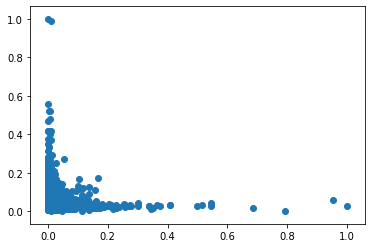

In [87]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(df_numerical['spaceAvailable'],df_numerical['price'])

In [166]:
airports = airports[airports.Country=='United States']
ports = airports[airports['Type']=='port']

In [ ]:
airports = 

In [170]:
ports['address'] = ports['Name'] + ' ' + ports['City'] + ' ' + ports['Country']

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [172]:
ports['latlon'] = ports['address'].apply(lambda x: do_geocode(x))

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [182]:
ny.sample(4)

address  \
136          348 Troutman St   
108           460 Buffalo Rd   
1363       11-13 Cypress Ave   
52    2099-2101 Mt Read Blvd   

                                              amenities  buildingSize  \
136                                     [Commuter Rail]       22000.0   
108                     [Bus Line, Fenced Lot, Signage]      488000.0   
1363                                               None        2200.0   
52    [24 Hour Access, Bus Line, Buss Ducts, Securit...       16710.0   

           city listingDate  price    propType  spaceAvailable  spaces state  \
136    Brooklyn  2019-10-17   2.08  Industrial           19499       2    NY   
108   Rochester  2019-11-14   0.25  Industrial            7604       2    NY   
1363  Ridgewood  2020-02-27   2.67  Industrial            2200       1    NY   
52    Rochester  2020-01-20   0.46  Industrial           16710       1    NY   

                 subType                                          transport  \
136   Office, Industrial  {'Nostrand Avenue Station Commuter Rail (West ...   
108           Industrial  {'Greater Rochester International Airport': [4...   
1363          Industrial  {'East New York Station Commuter Rail (West He...   
52            Industrial  {'Greater Rochester International Airport': [7...   

                            utilities  yearBuilt  yearRenovated  \
136             [Oil, Heating, Fired]       1931           1931   
108                                []       1965           1965   
1363  [Heating, Gas, Sewer, Lighting]       1942           1942   
52                                 []       1960           1960   

      ceilingHeight  numDriveIns  numLoadingDocks  \
136              10            1                1   
108              10            1                1   
1363             10            1                1   
52               10            1                2   

                                               propInfo  
136   Block-through between Troutman & Starr Street ...  
108   \nInterior industrial space accessible through...  
1363  \n2200 sqft warehouse on 2600 sqft lot. 2 year...  
52    4,000 SF of clean, air-conditioned manufacturi...

In [183]:
ny = df[df.state=='NY']

In [184]:
transport_df.sample(3)

index state                                  name  distance  timeTo  \
18623   6507    MD  Wollenweber'S Trucking & Warehousing       1.9     6.0   
7756    2573    OR                      Port of Portland       3.8     9.0   
2208     506    NY  Newark Liberty International Airport      19.2    35.0   

       speedOfTravel  
18623           19.0  
7756            25.3  
2208            32.9

In [185]:
transport = pd.merge(transport_df,airports, left_on='name',right_on='Name')

In [187]:
transport[transport.state=='NY']

index state                                   name  distance  timeTo  \
1006    289    NY                     La Guardia Airport      10.3    21.0   
1007    290    NY                     La Guardia Airport      23.4    40.0   
1008    291    NY                     La Guardia Airport      12.6    22.0   
1009    293    NY                     La Guardia Airport      13.6    20.0   
1010    296    NY                     La Guardia Airport      21.2    35.0   
...     ...   ...                                    ...       ...     ...   
2609  10713    NY  Buffalo Niagara International Airport      10.2    18.0   
2610  10714    NY  Buffalo Niagara International Airport      16.8    26.0   
2611  10715    NY  Buffalo Niagara International Airport       1.8     5.0   
2612  10716    NY  Buffalo Niagara International Airport       6.8    15.0   
2613  10723    NY  Buffalo Niagara International Airport      10.6    21.0   

      speedOfTravel                                   Name      City  \
1006           29.4                     La Guardia Airport  New York   
1007           35.1                     La Guardia Airport  New York   
1008           34.4                     La Guardia Airport  New York   
1009           40.8                     La Guardia Airport  New York   
1010           36.3                     La Guardia Airport  New York   
...             ...                                    ...       ...   
2609           34.0  Buffalo Niagara International Airport   Buffalo   
2610           38.8  Buffalo Niagara International Airport   Buffalo   
2611           21.6  Buffalo Niagara International Airport   Buffalo   
2612           27.2  Buffalo Niagara International Airport   Buffalo   
2613           30.3  Buffalo Niagara International Airport   Buffalo   

            Country ICAO   Latitude  Longitude Timezone DST     Type  
1006  United States  LGA  40.777199 -73.872597       -5   A  airport  
1007  United States  LGA  40.777199 -73.872597       -5   A  airport  
1008  United States  LGA  40.777199 -73.872597       -5   A  airport  
1009  United States  LGA  40.777199 -73.872597       -5   A  airport  
1010  United States  LGA  40.777199 -73.872597       -5   A  airport  
...             ...  ...        ...        ...      ...  ..      ...  
2609  United States  BUF  42.940498 -78.732201       -5   A  airport  
2610  United States  BUF  42.940498 -78.732201       -5   A  airport  
2611  United States  BUF  42.940498 -78.732201       -5   A  airport  
2612  United States  BUF  42.940498 -78.732201       -5   A  airport  
2613  United States  BUF  42.940498 -78.732201       -5   A  airport  

[535 rows x 15 columns]

In [268]:
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from time import sleep
geolocator = Nominatim(country_bias="United States")
def do_geocode(address, attempt=1, max_attempts=5):
    try:
        location = geolocator.geocode(address)
        if location == None:
            return
        
        else:
            sleep(1)
            return location.latitude, location.longitude
    except GeocoderTimedOut:
        if attempt <= max_attempts:
            return do_geocode(address, attempt=attempt+1)
        raise

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `country_bias` argument of the Nominatim.__init__ is deprecated and will be removed in geopy 2.0. Use Nominatim.geocode(country_codes='United States') instead.
  after removing the cwd from sys.path.
/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Using Nominatim with the default "geopy/1.21.0" `user_agent` is strongly discouraged, as it violates Nominatim's ToS https://operations.osmfoundation.org/policies/nominatim/ and may possibly cause 403 and 429 HTTP errors. Please specify a custom `user_agent` with `Nominatim(user_agent="my-application")` or by overriding the default `user_agent`: `geopy.geocoders.options.default_user_agent = "my-application"`. In geopy 2.0 this will become an exception.
  after removing the cwd from sys.path.


In [232]:
def geocode(address):
    try:
        results = geocoder.geocode(address)
        if results and len(results):
            return results[0]['geometry']
    except RateLimitExceededError as ex:
        pass

In [434]:
df = df_.copy()
df

address  \
947                    1511 FM 1960 Houston, TX USA   
948                    1515 FM 1960 Houston, TX USA   
949            10800 Blackhawk Blvd Houston, TX USA   
950                  6121 Griggs Rd Houston, TX USA   
955   10550 Old Bammel N Houston Rd Houston, TX USA   
...                                             ...   
1209          246 Jacintoport Blvd Saraland, AL USA   
1210    3520-3552 Lorna Ridge Dr Birmingham, AL USA   
1211            5155 Mobile South St Mobile, AL USA   
1212            13800 Mooresville Rd Athens, AL USA   
1213          140 Sparkman Dr NW Huntsville, AL USA   

                                              amenities  buildingSize  \
947         [Bus Line, Fenced Lot, Yard, Storage Space]       12000.0   
948         [Bus Line, Fenced Lot, Yard, Storage Space]       12000.0   
949   [Fenced Lot, Fluorescent Lighting, Air Conditi...       42000.0   
950                                        [Fenced Lot]       39399.0   
955                                                None        8640.0   
...                                                 ...           ...   
1209                                               None       22400.0   
1210                                               None       12500.0   
1211                                               None       34000.0   
1212                                               None      130000.0   
1213                                    [Storage Space]        9000.0   

            city listingDate  price    propType  spaceAvailable  spaces state  \
947      Houston  2019-05-01   0.85  Industrial           12000       1    TX   
948      Houston  2019-05-01   0.85  Industrial           12000       1    TX   
949      Houston  2019-05-02   0.45  Industrial           42000       1    TX   
950      Houston  2019-05-15   0.85  Industrial            5000       1    TX   
955      Houston  2019-06-10   0.68  Industrial            8640       1    TX   
...          ...         ...    ...         ...             ...     ...   ...   
1209    Saraland  2017-03-06   0.63  Industrial            5400       1    AL   
1210  Birmingham  2019-06-27   0.73        Flex            3240       1    AL   
1211      Mobile  2008-12-10   0.38  Industrial           34000       1    AL   
1212      Athens  2019-04-08   0.40  Industrial           90000       3    AL   
1213  Huntsville  2017-10-19   0.54  Industrial            9000       1    AL   

         subType                                          transport  \
947   Industrial  {'Houston George Bush Intercontinental Airport...   
948   Industrial  {'Houston George Bush Intercontinental Airport...   
949   Industrial  {'William P. Hobby Airport': [5.5, 14.0, 23.6]...   
950   Industrial  {'William P. Hobby Airport': [7.2, 18.0, 24.0]...   
955   Industrial  {'Houston George Bush Intercontinental Airport...   
...          ...                                                ...   
1209  Industrial  {'Mobile Regional Airport': [19.7, 35.0, 33.8]...   
1210        Flex  {'Birmingham-Shuttlesworth International Airpo...   
1211  Industrial  {'Mobile Regional Airport': [14.4, 32.0, 27.0]...   
1212  Industrial  {'Huntsville International-Carl T. Jones Field...   
1213  Industrial                                                 {}   

                                    utilities  yearBuilt  yearRenovated  \
947                         [Sewer, Lighting]       2019           2019   
948                         [Sewer, Lighting]       2019           2019   
949   [Heating, Sewer, Fluorescent, Lighting]       1985           1985   
950                            [Heating, Gas]       1965           1965   
955                                        []       2006           2006   
...                                       ...        ...            ...   
1209                                       []       2003           2003   
1210                                       []       1986           1986   
1211 

In [244]:
df['latlon'] = df['address'].apply(lambda x: geocode(x))

In [261]:
df_proc = df[df.latlon.isna()][['address']]

In [265]:
for addr in df_proc[:3]:
    print(do_geocode(addr))

(-37.90323075, 144.758564914636)


In [318]:
step=100
for n in range(0,1):
    temp = df_proc['address'][n*step:(n+1)*step].apply(lambda x: do_geocode(x))
    latlon.append(temp)
    sleep(10)

In [425]:
a = pd.concat(latlon)

In [426]:
a = a.reset_index()

In [427]:
a.columns = ['index','coords']

In [428]:
a = a.drop_duplicates(subset='index')

In [429]:
df_latlon = pd.merge(df_proc,a,on='index',how='left')

In [430]:
df_latlon

level_0  index                                      address  \
0           0    306       16150 W Lincoln Ave New Berlin, WI USA   
1           1    323        8100 N Teutonia Ave Milwaukee, WI USA   
2           2    324                  275 Bruce St Verona, WI USA   
3           3    326            1335 Plainview Dr Oshkosh, WI USA   
4           4    327             Enterprise Dr Sturtevant, WI USA   
...       ...    ...                                          ...   
6729     6729   1209        246 Jacintoport Blvd Saraland, AL USA   
6730     6730   1210  3520-3552 Lorna Ridge Dr Birmingham, AL USA   
6731     6731   1211          5155 Mobile South St Mobile, AL USA   
6732     6732   1212          13800 Mooresville Rd Athens, AL USA   
6733     6733   1213        140 Sparkman Dr NW Huntsville, AL USA   

                                       coords  
0     (43.00274132258065, -88.11424972580646)  
1                     (43.110111, -87.949486)  
2     (42.97803720298252, -89.54016636718835)  
3                                        None  
4                   (42.7139321, -87.9082566)  
...                                       ...  
6729      (30.804928291666666, -88.069106375)  
6730        (42.13542545, -71.07250484319789)  
6731               (39.7743726, -104.7481278)  
6732                  (34.756419, -86.877171)  
6733                 (39.929054, -105.103766)  

[6734 rows x 4 columns]

In [399]:
df['coords'] = df['latlon'].apply(lambda x: changeLatLon(x))

In [396]:
def changeLatLon(x):
    if x:
        return x['lat'],x['lng']
    else:
        return

In [435]:
pd.merge(df, df_latlon[['address','coords']], on='address', how='left')

address  \
0                      1511 FM 1960 Houston, TX USA   
1                      1515 FM 1960 Houston, TX USA   
2              10800 Blackhawk Blvd Houston, TX USA   
3                    6121 Griggs Rd Houston, TX USA   
4     10550 Old Bammel N Houston Rd Houston, TX USA   
...                                             ...   
9594    3520-3552 Lorna Ridge Dr Birmingham, AL USA   
9595            5155 Mobile South St Mobile, AL USA   
9596            5155 Mobile South St Mobile, AL USA   
9597            13800 Mooresville Rd Athens, AL USA   
9598          140 Sparkman Dr NW Huntsville, AL USA   

                                              amenities  buildingSize  \
0           [Bus Line, Fenced Lot, Yard, Storage Space]       12000.0   
1           [Bus Line, Fenced Lot, Yard, Storage Space]       12000.0   
2     [Fenced Lot, Fluorescent Lighting, Air Conditi...       42000.0   
3                                          [Fenced Lot]       39399.0   
4                                                  None        8640.0   
...                                                 ...           ...   
9594                                               None       12500.0   
9595                                               None       34000.0   
9596                                               None       34000.0   
9597                                               None      130000.0   
9598                                    [Storage Space]        9000.0   

            city listingDate  price    propType  spaceAvailable  spaces state  \
0        Houston  2019-05-01   0.85  Industrial           12000       1    TX   
1        Houston  2019-05-01   0.85  Industrial           12000       1    TX   
2        Houston  2019-05-02   0.45  Industrial           42000       1    TX   
3        Houston  2019-05-15   0.85  Industrial            5000       1    TX   
4        Houston  2019-06-10   0.68  Industrial            8640       1    TX   
...          ...         ...    ...         ...             ...     ...   ...   
9594  Birmingham  2019-06-27   0.73        Flex            3240       1    AL   
9595      Mobile  2008-12-10   0.38  Industrial           34000       1    AL   
9596      Mobile  2008-12-10   0.38  Industrial           34000       1    AL   
9597      Athens  2019-04-08   0.40  Industrial           90000       3    AL   
9598  Huntsville  2017-10-19   0.54  Industrial            9000       1    AL   

         subType                                          transport  \
0     Industrial  {'Houston George Bush Intercontinental Airport...   
1     Industrial  {'Houston George Bush Intercontinental Airport...   
2     Industrial  {'William P. Hobby Airport': [5.5, 14.0, 23.6]...   
3     Industrial  {'William P. Hobby Airport': [7.2, 18.0, 24.0]...   
4     Industrial  {'Houston George Bush Intercontinental Airport...   
...          ...                                                ...   
9594        Flex  {'Birmingham-Shuttlesworth International Airpo...   
9595  Industrial  {'Mobile Regional Airport': [14.4, 32.0, 27.0]...   
9596  Industrial  {'Mobile Regional Airport': [14.4, 32.0, 27.0]...   
9597  Industrial  {'Huntsville International-Carl T. Jones Field...   
9598  Industrial                                                 {}   

                                    utilities  yearBuilt  yearRenovated  \
0                           [Sewer, Lighting]       2019           2019   
1                           [Sewer, Lighting]       2019           2019   
2     [Heating, Sewer, Fluorescent, Lighting]       1985           1985   
3                              [Heating, Gas]       1965           1965   
4                                          []       2006           2006   
...                                       ...        ...            ...   
9594                                       []       1986           1986   
9595                        [Sewer, Lighting]       2007           2007   
9596 

In [436]:
df.loc[df.coords.isna()]['coords'] = df_latlon['coords']

AttributeError: 'DataFrame' object has no attribute 'coords'

In [420]:
temp = df[['address','coords','state']][~df['coords'].isna()]

In [422]:
temp.groupby(['state']).agg({'address': 'count'})

address
state         
CA          33
IL          10
NC         303
ND          39
NM          25
NY         386
OH         427
OK         163
OR         210
PA         312
RI          41
SC         205
TN         164
TX          99
WI          49
WY          17

In [424]:
df

name      pop        lat         lon  \
0             New York   8287238  40.730599  -73.986581   
1          Los Angeles   3826423  34.053717 -118.242727   
2              Chicago   2705627  41.875555  -87.624421   
3              Houston   2129784  29.758938  -95.367697   
4         Philadelphia   1539313  39.952335  -75.163789   
...                 ...      ...        ...         ...   
3223      Spanish Fort      7102  30.674913  -87.915272   
3224        Plaquemine      7102  30.289083  -91.234274   
3225  Milton-Freewater      7102  45.932635 -118.387743   
3226            Benton      7096  36.034529  -88.101285   
3227        Ocean City      7094  39.277616  -74.574600   

                                                  text  
0             New York <br>Population 8.287238 million  
1          Los Angeles <br>Population 3.826423 million  
2              Chicago <br>Population 2.705627 million  
3              Houston <br>Population 2.129784 million  
4         Philadelphia <br>Population 1.539313 million  
...                                                ...  
3223      Spanish Fort <br>Population 0.007102 million  
3224        Plaquemine <br>Population 0.007102 million  
3225  Milton-Freewater <br>Population 0.007102 million  
3226            Benton <br>Population 0.007096 million  
3227        Ocean City <br>Population 0.007094 million  

[3228 rows x 5 columns]

In [690]:
df = pd.read_csv('./extra-data/us_port_trade_by_state.csv')

In [691]:
top10 = df[['Port name','Total trade']].head(10).set_index('Port name')

In [697]:
top10['Total trade'] = top10['Total trade'].str.replace(',','').astype(float)/1e6

In [700]:
top10['Total trade'] = top10['Total trade'].round(1)

In [701]:
top10

Total trade
Port name                               
Port of South Louisiana            238.6
Port of Houston                    229.2
Port of New York                   123.3
Port of Beaumont                    94.4
Port of Long Beach                  84.5
Port of Hampton Roads               78.7
Port of New Orleans                 77.2
Port of Corpus Christi              76.2
Port of Greater Baton Rouge         63.9
Port of Los Angeles                 57.9

In [735]:
airport = pd.read_csv('./extra-data/us-airports.csv')

In [747]:
airport = airport[['name','latitude_deg','longitude_deg']].iloc[:100]

In [748]:
airport.columns = ['name','lat','lon']

In [742]:
np.unique(airport.type.values)

array(['balloonport', 'closed', 'heliport', 'large_airport',
       'medium_airport', 'seaplane_base', 'small_airport'], dtype=object)

In [744]:
airport.groupby('type').agg({'name':'count'})

name
type                 
balloonport        17
closed           1720
heliport         6237
large_airport     170
medium_airport    687
seaplane_base     568
small_airport   13553